# Forecasting Carbon Futures Prices with Bayesian VAR Model

***Huseyin Polat, 437969***

**References:**

- [Carbon emissions futures data](https://www.investing.com/commodities/carbon-emissions-historical-data)
- [BVAR package documentation](https://cran.r-project.org/web/packages/BVAR/BVAR.pdf)
- [BVAR package utilization - reference article](https://cran.r-project.org/web/packages/BVAR/vignettes/article.pdf)

## 1. Import libraries

In [205]:
# Install and load necessary packages if not already installed
if (!requireNamespace("BVAR", quietly = TRUE)) {
  install.packages("BVAR")
}
if (!requireNamespace("coda", quietly = TRUE)) {
  install.packages("coda")
}
if (!requireNamespace("zoo", quietly = TRUE)) {
  install.packages("zoo")
}
if (!requireNamespace("tidyverse", quietly = TRUE)) {
  install.packages("tidyverse")
}
if (!requireNamespace("Metrics", quietly = TRUE)) {
  install.packages("Metrics")
}

# Load necessary libraries
library(BVAR)
library(coda)
library(zoo)
library(tidyverse)
library(Metrics)

## 2. Import dataset

In [313]:
# Load the dataset
carbon_data <- read.csv("Carbon Emissions Futures Historical Data.csv")

# Convert dates to Date format
carbon_data$Date <- as.Date(carbon_data$Date, format = "%m/%d/%Y")

# Limit the dataset to start from 2022 to the last day of May 2024
carbon_data <- carbon_data %>% filter(Date <= "2024-05-31") %>% filter(Date >= "2022-01-01")

head(carbon_data)

,Date,Price,Open,High,Low,Vol.,Change..
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,2024-05-31,74.07,75.48,76.42,73.85,19.01K,-1.50%
2,2024-05-30,75.20,73.66,75.84,73.37,19.23K,1.69%
3,2024-05-29,73.95,74.50,75.60,72.95,21.29K,-0.87%
4,2024-05-28,74.60,75.99,76.24,74.15,20.35K,-2.50%
5,2024-05-27,76.51,75.70,76.99,75.58,11.68K,0.96%
6,2024-05-24,75.78,76.10,76.70,73.90,20.91K,-0.42%


## 3. Data transformation

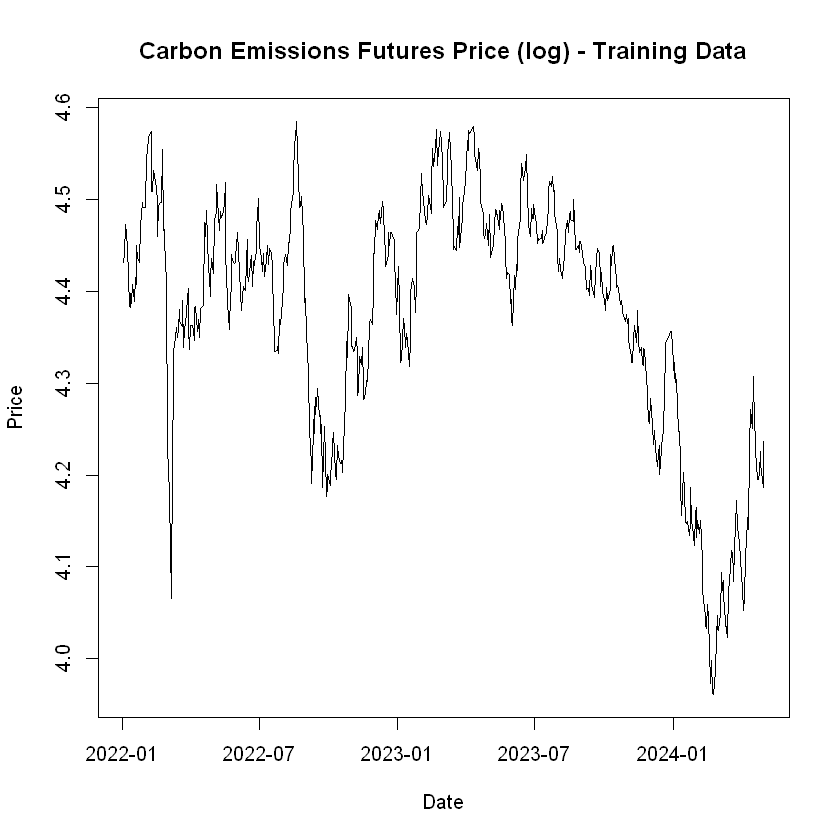

In [314]:
# Log-transform the columns
carbon_data$Price <- log(carbon_data$Price)
carbon_data$High <- log(carbon_data$High)
carbon_data$Low <- log(carbon_data$Low)

# Split the data into training and test sets
# May 2024 is treated as test period
train_data <- carbon_data %>% filter(Date < "2024-05-01")
test_data <- carbon_data %>% filter(Date >= "2024-05-01")

# Convert training data to a time series object
train_ts <- zoo(train_data[, c("Price", "High", "Low")], order.by = train_data$Date)

# Plot the training data
plot(train_ts$Price, main = "Carbon Emissions Futures Price (log) - Training Data", ylab = "Price", xlab = "Date")

# Convert the training time series to a matrix
train_matrix <- as.matrix(coredata(train_ts))

## 4. Model Training

In [317]:
# Define the lag order
lags <- 3

# Fit the BVAR model
model <- bvar(train_matrix, lags = lags, n.iter = 500000, n.burn = 100000, n.chains = 50)

# Check convergence diagnostics
summary(model)

Optimisation concluded.
Posterior marginal likelihood: 4615.69
Hyperparameters: lambda = 3.91445
  |======================================================================| 100%
Finished MCMC after 6.79 secs.


Bayesian VAR consisting of 594 observations, 3 variables and 3 lags.
Time spent calculating: 6.79 secs
Hyperparameters: lambda 
Hyperparameter values after optimisation: 3.91445
Iterations (burnt / thinning): 10000 (5000 / 1)
Accepted draws (rate): 5000 (1)

Numeric array (dimensions 10, 3) of coefficient values from a BVAR.
Median values:
            Price   High    Low
constant    0.122  0.113  0.031
Price-lag1  0.932  0.888  1.006
High-lag1   0.133  0.208 -0.206
Low-lag1   -0.039 -0.112  0.301
Price-lag2 -0.039  0.055 -0.124
High-lag2   0.044 -0.009  0.035
Low-lag2    0.084 -0.023  0.069
Price-lag3 -0.097 -0.022 -0.081
High-lag3  -0.151 -0.025 -0.157
Low-lag3    0.106  0.016  0.148

Numeric array (dimensions 3, 3) of variance-covariance values from a BVAR.
Median values:
      Price High Low
Price 0.001    0   0
High  0.000    0   0
Low   0.000    0   0

Log-Likelihood: 4909.336 

Bayesian VAR consisting of 594 observations, 3 variables and 3 lags.
Time spent calculating: 6.79 secs
Hyperparameters: lambda 
Hyperparameter values after optimisation: 3.91445
Iterations (burnt / thinning): 10000 (5000 / 1)
Accepted draws (rate): 5000 (1)


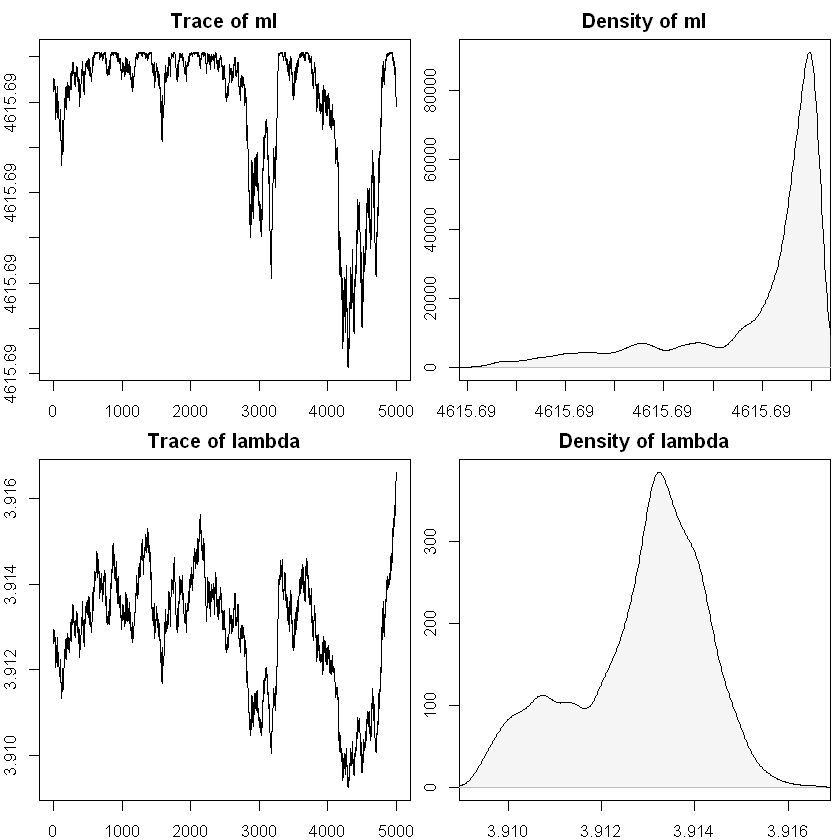

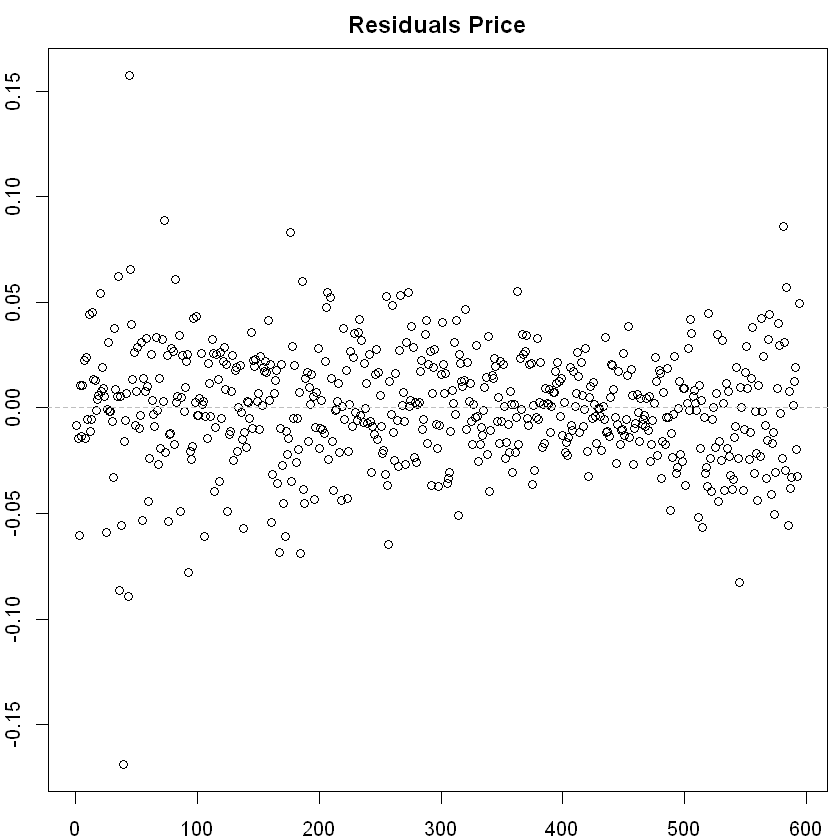

In [318]:
# Model details
print(model)
# Trace and densities plot
plot(model)
# Plot residuals of the model for Price variable
plot(residuals(model, type = "mean"), vars = c("Price"))

**The samples for 𝜇 and 𝜆 exhibit volatility, yet the density distributions display singular peaks.**

**The residuals appear to be primarily centered around 0, with the majority falling within the range of +/- 5%, occasionally exceeding this threshold.**

## 5. Forecasting

In [322]:
# Generate forecast for May 2024 with confidence bands
forecast_result <- predict(model, horizon = dim(test_data)[1], conf_bands = c(0.05, 0.1))

# Extract forecasted values, only for Price variable
forecast_mean <- apply(forecast_result$fcast[,,1], 2, mean)
forecast_lower <- forecast_result$quants[,,1][1,]
forecast_upper <- forecast_result$quants[,,1][5,]

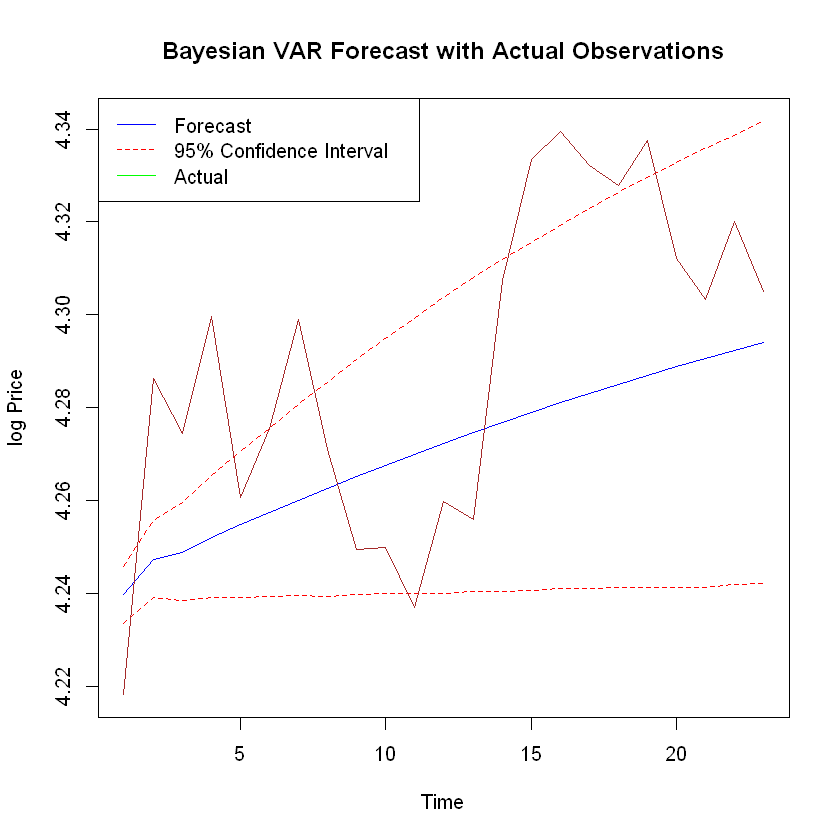

In [323]:
# Extract actual observations for the test period
actual_obs <- test_data %>% arrange(Date) %>% select(Price)

# Plot the forecasts, confidence bands, and actual observations
plot(forecast_mean, type = "l", col = "blue", ylim = range(c(actual_obs, forecast_lower, forecast_upper)),
     main = "Bayesian VAR Forecast with Actual Observations", xlab = "Time", ylab = "log Price")
lines(forecast_lower, col = "red", lty = 2)
lines(forecast_upper, col = "red", lty = 2)
lines(actual_obs$Price, col = "brown", lty = 1)
legend("topleft", legend = c("Forecast", "95% Confidence Interval", "Actual"), col = c("blue", "red", "green"), lty = c(1, 2, 1))

### In the testing period, the forecast captures the trend of carbon emissions futures prices. 

**However, there are instances where the actual prices deviate outside the 95% confidence intervals. While the model demonstrates stability in its predictions, it's evident that the price of carbon emissions futures remains highly volatile during the forecasted period.**